

1.   Extract audio from the source video
2.   Split video to phonemes and get timestamps of a frames in the video for these phonemes
3.   Get latent representation in StyleGAN for every phoneme frame
4.   Get phoneme list for target audio $p_{t_1}...p_{t_N}$
5.   For every pair $p_{t_{i-1}}$, $p_{t_{i}}$ find intermediate representations to make smooth lip motion
6.   Save these images as frames and create output video 


In [0]:
import cv2
import os
import pickle
import PIL.Image
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import json
from keras.models import load_model

Using TensorFlow backend.


# Extract audio

In [0]:
!ffmpeg -i /input/source_video.mp4 ./source_audio.mp3

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [0]:
source_text = '''t minus everything 
you bring what you can bring
you stay light on your feet
you spend your life running

pulling me like gravity 
the beast is fully hungry 
i try to crawl away
i will not be pray today

in armageddon
without a weapon
pushing forward
but don't know my mission
so it's on to the next level
no turning back
next level'''

In [0]:
with open('input/source_text.txt', 'w') as f:
    f.write(source_text)

# Split to phonemes

You can install docker container from https://github.com/lowerquality/gentle to launch local server (it will speed up the process) or simply use:

In [0]:
!curl -F "audio=@source_audio.mp3" -F "transcript=@input/source_text.txt" \
"http://gentle-demo.lowerquality.com/transcriptions?async=false" >> source_aligned.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  402k    0 30096  100  373k   1788  22731  0:00:16  0:00:16 --:--:--  7512


In [0]:
source_aligned = json.load(open('source_aligned.json', 'r'))
for word in source_aligned['words']:
  for phone in word['phones']:
    phone['phone'] = phone['phone'].split('_')[0]


In [0]:
source_aligned['words'][:3]

[{'alignedWord': 't',
  'case': 'success',
  'end': 0.4,
  'endOffset': 1,
  'phones': [{'duration': 0.1, 'phone': 't'},
   {'duration': 0.1, 'phone': 'iy'}],
  'start': 0.2,
  'startOffset': 0,
  'word': 't'},
 {'alignedWord': 'minus',
  'case': 'success',
  'end': 0.8600000000000001,
  'endOffset': 7,
  'phones': [{'duration': 0.1, 'phone': 'm'},
   {'duration': 0.12, 'phone': 'ay'},
   {'duration': 0.07, 'phone': 'n'},
   {'duration': 0.07, 'phone': 'ah'},
   {'duration': 0.1, 'phone': 's'}],
  'start': 0.4,
  'startOffset': 2,
  'word': 'minus'},
 {'alignedWord': 'everything',
  'case': 'success',
  'end': 1.53,
  'endOffset': 18,
  'phones': [{'duration': 0.1, 'phone': 'eh'},
   {'duration': 0.08, 'phone': 'v'},
   {'duration': 0.07, 'phone': 'r'},
   {'duration': 0.05, 'phone': 'iy'},
   {'duration': 0.09, 'phone': 'th'},
   {'duration': 0.07, 'phone': 'ih'},
   {'duration': 0.14, 'phone': 'ng'}],
  'start': 0.93,
  'startOffset': 8,
  'word': 'everything'}]

Let's create a dict phoneme -> timestamp

In [0]:
phonemes_dict = dict()

for word in source_aligned['words']:
  
  timestamp = word['start']
  for phone in word['phones']:
    if phone['phone'] not in phonemes_dict:
      phonemes_dict[phone['phone']] = timestamp + (phone['duration'] / 2) # let's pick a middle of a phoneme
    
    timestamp += phone['duration']

# add neutral
phonemes_dict['NEUTRAL'] = 23.0

In [0]:
RAW_DIR = 'raw/'
!mkdir {RAW_DIR}

mkdir: cannot create directory ‘raw/’: File exists


Extract frames from the video

In [0]:
cap = cv2.VideoCapture("input/source_video.mp4")

for phoneme, timestamp in tqdm(phonemes_dict.items()):
  
  cap.set(cv2.CAP_PROP_POS_MSEC, timestamp * 1_000)

  ret, frame = cap.read()
  if ret:
    cv2.imwrite(f'raw/{phoneme}.jpg', frame)
  else:
    print(phoneme, timestamp)
    break
  
cap.release()

Let's align the images

In [0]:
ALIGNED_DIR = 'align/'
!mkdir {ALIGNED_DIR}

mkdir: cannot create directory ‘align/’: File exists


In [0]:
!git clone https://github.com/pbaylies/stylegan-encoder

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 453, done.
remote: Total 453 (delta 0), reused 0 (delta 0), pack-reused 453
Receiving objects: 100% (453/453), 12.61 MiB | 6.60 MiB/s, done.
Resolving deltas: 100% (257/257), done.


In [0]:
!python stylegan-encoder/align_images.py {RAW_DIR} {ALIGNED_DIR} --output_size=512

Let's show some phonemes with corresponding frames from the video:

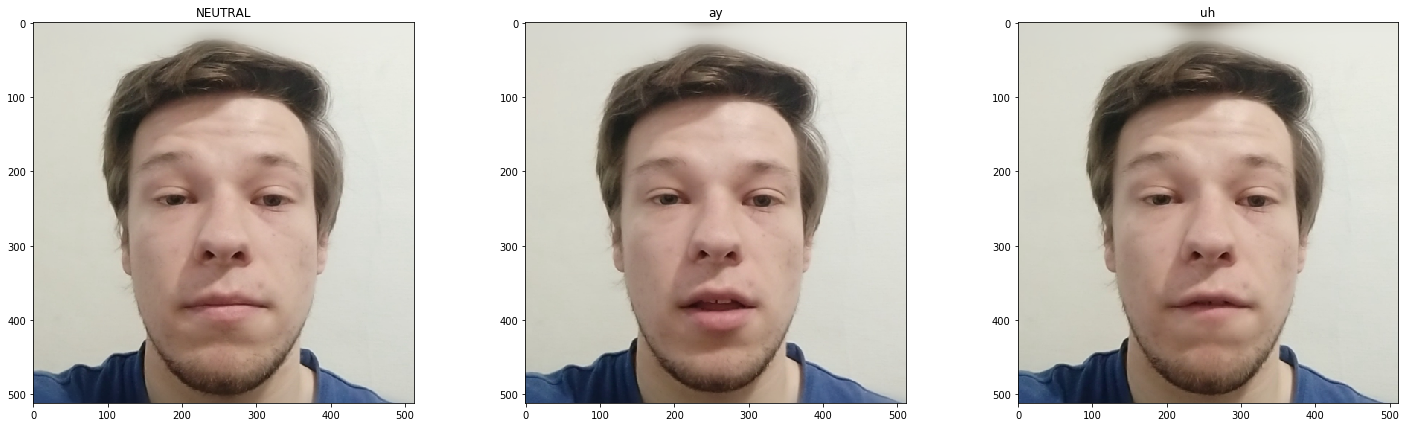

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(25, 7))

for i, filename in enumerate(['NEUTRAL', 'ay', 'uh']):
  axes[i].set_title(filename)
  axes[i].imshow(plt.imread(ALIGNED_DIR + filename + '_01.png'))

# Get latent representations

In this implication pretrained ResNet has been used in order to find initial latent representation faster

In [0]:
GENERATED_DIR = 'generated_images/'
LATENT_DIR = 'latent_representations/'

!mkdir {GENERATED_DIR}
!mkdir {LATENT_DIR}

In [0]:
!gdown https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
!mkdir data
!mv finetuned_resnet.h5 data

Downloading...
From: https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
To: /content/finetuned_resnet.h5
330MB [00:04, 67.6MB/s]


In [0]:
resnet_model = load_model('data/finetuned_resnet.h5')
print(resnet_model.summary())


















Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 144)         295056    
_________________________________________________________________
reshape_1 (Reshape)          (None, 96, 96)            0         
_________________________________________________________________
locally_connected1d_1 (Local (None, 96, 96)            893952    
_________________________________________________________________
permute_1 (Permute)          (None, 96, 96)            0         
_________________________________________________________________
locally_connected1d_2 (Local (None, 96, 96)            893952    
_________________________________________________________________
permute_2 (Permute)          (None, 9

We need to find LR for each phoneme. It will took about 1000 iterations to make the result look like the original image. However, we can use LR of a neutral face as initial LR to speed up this process. In this case we need only 100 iterations

At first let's find the latent representation for a neutral face

In [0]:
NEUTRAL_DIR = 'neutral_origin_face/'
!mkdir {NEUTRAL_DIR}

!cp {ALIGNED_DIR}NEUTRAL_01.png {NEUTRAL_DIR}

In [0]:
!python stylegan-encoder/encode_images.py --batch_size=1 --output_video=True \
    --lr=0.01 --decay_rate=0.8 \
    --load_resnet='data/finetuned_resnet.h5' \
    --iterations=1000 --use_l1_penalty=0.3 {NEUTRAL_DIR} {GENERATED_DIR} {LATENT_DIR}

To use LR of a neutral face, we need to specify the `load_last` parameter

In [0]:
INITIAL_LATENT_REPR_DIR = 'initial_latent_representations/'
!mkdir {INITIAL_LATENT_REPR_DIR}

Set initial LR for every phoneme:

In [0]:
%%bash
for filename in align/*.*; do
  phoneme=$(basename "${filename%.*}")
  cp latent_representations/NEUTRAL_01.npy initial_latent_representations/${phoneme}.npy
done

Get LRs for phonemes:

In [0]:
!python stylegan-encoder/encode_images.py --batch_size=1 \
  --lr=0.01 --decay_rate=0.8 \
  --iterations=100 --use_l1_penalty=0.3 {ALIGNED_DIR} {GENERATED_DIR} {LATENT_DIR} \
  --load_last '{INITIAL_LATENT_REPR_DIR}'

Let's plot some source images with generated images

In [0]:
os.chdir('stylegan-encoder')

import dnnlib
import dnnlib.tflib as tflib
import config
from encoder.generator_model import Generator
import os

URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)

def generate_image(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img.resize((256, 256))


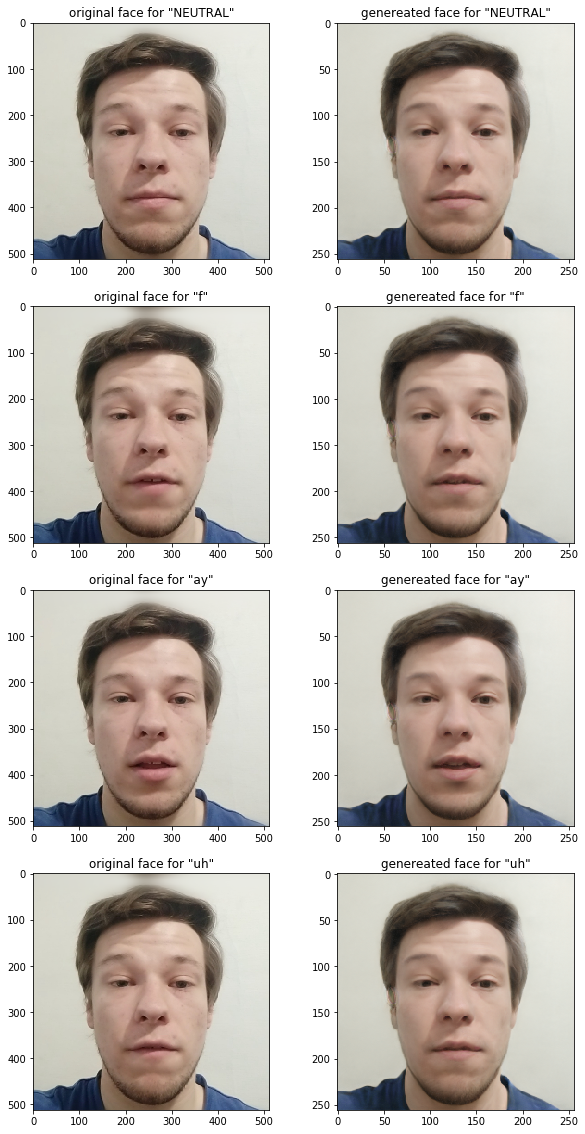

In [0]:
images = ['NEUTRAL', 'f', 'ay', 'uh']

fig, axes = plt.subplots(len(images), 2, figsize=(10,20))

for i, phoneme in enumerate(images):
    axes[i, 0].set_title('original face for "{}"'.format(phoneme))
    axes[i, 0].imshow(plt.imread('../align/{}_01.png'.format(phoneme)))

    lat_repr = np.load('../latent_representations/{}_01.npy'.format(phoneme))
    image = np.array(generate_image(lat_repr))
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    axes[i, 1].set_title('genereated face for "{}"'.format(phoneme))
    axes[i, 1].imshow(image)


# Get phonemes for target audio 

You can use any other text and audio, it this case we use the same phonemes as in input

In [0]:
timestamps_list = []  # [{'timestamp': 0.24, 'phone': 't'}, ...]
output_align = '../source_aligned.json'

for word in json.load(open(output_align, 'r'))['words']:
# for word in json.load(open('source_aligned.json', 'r'))['words']:
    timestamp = word['start']
    
    for phone in word['phones']:
        timestamps_list.append({'timestamp': timestamp,
                                'phone': phone['phone'].split('_')[0]})
        
        timestamp += phone['duration']

In [0]:
# find pauses
insert_after = []
for i, _ in enumerate(timestamps_list[:-1]):
  diff = timestamps_list[i + 1]['timestamp'] - timestamps_list[i]['timestamp']

  if diff > 0.5:
    insert_after.append({'index_after': i,
                         'value': timestamps_list[i]['timestamp'] + 0.1})

In [0]:
# insert neutral face
for i, x in enumerate(insert_after):
  timestamps_list.insert(x['index_after'] + 1 + i, {'timestamp': x['value'],
                                                    'phone': 'NEUTRAL'})

In [0]:
fps = 30

# calculate frame index for every timestamp
for x in timestamps_list:
  x['frame_index'] = int(x['timestamp'] * fps)
  
timestamps_list.insert(0, {'timestamp': 0,
                           'phone': 'NEUTRAL',
                           'frame_index': 0})

# Find output LRs and create frames

In [0]:
len(timestamps_list)

224

In [0]:
frame_width, frame_height = 256, 256

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter('../output_video.avi',
                      cv2.VideoWriter_fourcc('M','J','P','G'),#*'MP4V'),  #'M','J','P','G'),
                      fps,
                      (frame_width,frame_height))
 
for i, phoneme_item in tqdm(list(enumerate(timestamps_list))):
    # print('i={}'.format(i))
    # if i == 50:
    #     break

    curr_lat_repr = np.load('../latent_representations/{}_01.npy'.format(phoneme_item['phone']))

    if (i + 1)< len(timestamps_list):
        next_lat_repr = np.load('../latent_representations/{}_01.npy'\
                                .format(timestamps_list[i+1]['phone']))
        next_frame_index = timestamps_list[i+1]['frame_index']
    else:
        next_lat_repr = np.load('../latent_representations/NEUTRAL_01.npy')
        next_frame_index = phoneme_item['frame_index'] + 5 # add some frames to the end

    lat_direction = (next_lat_repr - curr_lat_repr) / (next_frame_index - phoneme_item['frame_index'])

    # add interpolation vector
    for j in range(next_frame_index - phoneme_item['frame_index']):
        img = generate_image(curr_lat_repr + lat_direction * j)
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        out.write(img)

             
out.release()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


In [0]:
# add audio
!ffmpeg -i ../output_video.avi -i ../source_audio.mp3 -c:v copy \
        -c:a aac -strict experimental -map 0:v:0 \
        -map 1:a:0 ../output_with_sound.mp4 -y

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena